<a href="https://colab.research.google.com/github/snehangsude/Football-Visualizations/blob/main/Food_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Classifier

### Importing libraries

In [1]:
!pip install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 112 kB 5.4 MB/s 
     |████████████████████████████████| 455 kB 41.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
voila 0.3.0 requires nbconvert<7,>=6.0.0, but you have nbconvert 5.6.1 which is incompatible.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.


In [2]:
fastbook.setup_book()

### Importing Data from DuckDuckGo

In [3]:
food_type = ['pizza', 'burger', 'lasagna', 'sandwich', 'waffle', ]
path = Path('foods')
path.mkdir(exist_ok=True)

In [4]:
for food in food_type:
    dest = (path/food)
    dest.mkdir(exist_ok= True)
    results = search_images_ddg(f'{food}')
    download_images(dest, urls=results)

In [5]:
images = get_image_files(path)
images

(#1636) [Path('foods/las.jpg'),Path('foods/burger/00000076.jpg'),Path('foods/burger/00000047.jpg'),Path('foods/burger/00000024.jpg'),Path('foods/burger/00000125.jpg'),Path('foods/burger/00000181.jpg'),Path('foods/burger/00000068.jpg'),Path('foods/burger/00000015.png'),Path('foods/burger/00000276.jpg'),Path('foods/burger/00000092.jpg')...]

#### Checking for files which aren't images

In [6]:
failed  = verify_images(images)
failed

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


(#3) [Path('foods/pizza/00000228.jpg'),Path('foods/waffle/00000067.jpg'),Path('foods/lasagna/00000195.jpg')]

In [7]:
failed.map(Path.unlink)

(#3) [None,None,None]

In [8]:
images

(#1636) [Path('foods/las.jpg'),Path('foods/burger/00000076.jpg'),Path('foods/burger/00000047.jpg'),Path('foods/burger/00000024.jpg'),Path('foods/burger/00000125.jpg'),Path('foods/burger/00000181.jpg'),Path('foods/burger/00000068.jpg'),Path('foods/burger/00000015.png'),Path('foods/burger/00000276.jpg'),Path('foods/burger/00000092.jpg')...]

### Creating the DataBlock object which:

- Denotes what are we classifying (Images as `ImageBlock` and `CategoryBlock` as names of folder which are category of the image
- `get_items` which helps ideentify the image files
- `splitter` helps with splitting the dataset
- `get-y` helps with getting the parent label ~ See docs
- `item_tfms` helps with Resizing indivisual images to 128 pixels

In [79]:
foods = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=34),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [80]:
dls = foods.dataloaders(path)

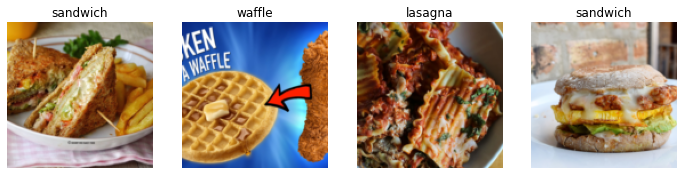

In [81]:
dls.valid.show_batch(max_n=4, nrows=1)

In [82]:
foods = foods.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = foods.dataloaders(path)

In [83]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,2.007808,0.680670,0.211039,01:52


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.979245,0.437349,0.159091,01:51
1,0.822340,0.370102,0.103896,01:52
2,0.651273,0.292469,0.107143,01:50
3,0.566914,0.249825,0.090909,01:49
4,0.480198,0.220232,0.074675,01:49
5,0.433123,0.222573,0.077922,01:51


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


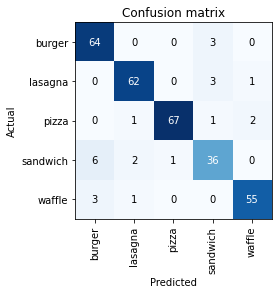

In [84]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

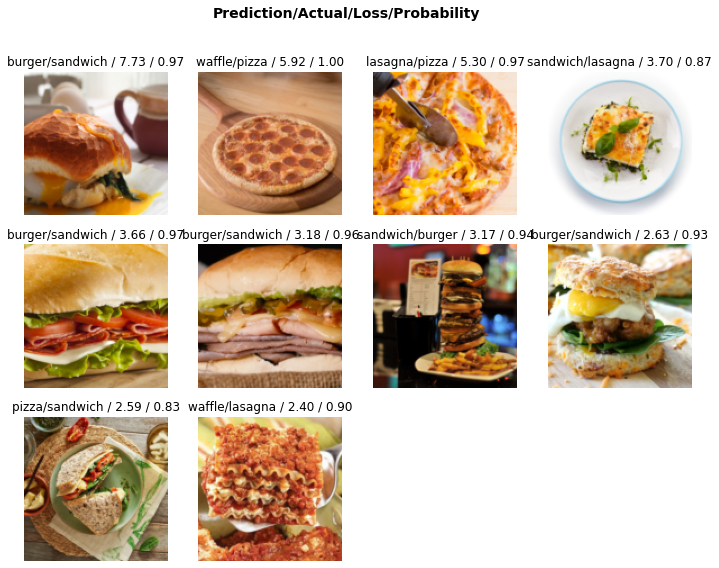

In [85]:
def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

plot_top_losses_fix(interp, 10)

In [86]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [78]:
for idx in cleaner.delete(): 
    cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): 
    shutil.move(str(cleaner.fns[idx]), path/f'{cat}0')

In [87]:
learn_inf = load_learner(path/'export.pkl')

In [88]:
ims = ['https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.handi-foil.com%2Fwp-content%2Fuploads%2F2020%2F09%2F15-Easy-Beef-Lasagna-on-a-double-white-plate-with-a-fork-next-to-it.jpg&f=1&nofb=1']

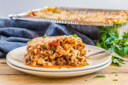

In [89]:
dest = 'foods/las.jpg'
download_url(ims[0], dest)

im = Image.open(dest)
im.to_thumb(128,128)

In [90]:
learn_inf.predict('foods/las.jpg')

('lasagna',
 TensorBase(2),
 TensorBase([1.6213e-05, 1.1552e-01, 8.8170e-01, 1.4263e-05, 1.0923e-03, 1.6568e-03]))

In [91]:
learn_inf.dls.vocab

['burger', 'foods', 'lasagna', 'pizza', 'sandwich', 'waffle']

In [92]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [93]:
btn_upload = SimpleNamespace(data = ['foods/las.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [102]:

out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))

In [103]:
pred,pred_idx,probs = learn_inf.predict(img)

In [104]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: lasagna; Probability: 0.8817')

In [105]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [106]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [107]:
btn_upload = widgets.FileUpload()

In [108]:
VBox([widgets.Label('Select the Food!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [109]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
